# Aufgabe für die Projektgruppe 5

Bearbeiten Sie die folgende Aufgabe:

Ihr Auftraggeber ist eine Familie, welche eine Beratung von Ihnen benötigt. Sie besitzt ein kleines altes Windrad, welches nur für den Eigenverbrauch genutzt wird sowie eine PV Anlage. Die Familie möchte von Ihnen wissen, ob Sie Kosten durch die Investition in verschiedene Komponenten ihres Energiesystems einsparen kann. 

Nehmen Sie dabei die folgenden Angaben an:
* Nennleistung der Windernergieanlage: 5 kW (Keine EEG- Vergütung)
* Nennleistung der PV-Anlage 9 kWp (70% Kappungsgrenze berücksichtigen)
* Die Anschlussleistung an das elektrische Netz beträgt 15 kW
* Die Heizleistung des Erdgaskessel liegt bei 20 kW, der Wirkungsgrad ist 99%
* Erdgaspreis: 7 cent/kWh
* Strompreis: 30 cent/kWh
* EEG-Vergütung PV Anlage: 12,30 cent/kWh

Prüfen und kombinieren Sie mindestens drei der unten aufgeführten Optionen und bewerten Sie diese nach ihrer wirtschaftlicher Vorteilhaftigkeit. Unter den gewählten Optionen sollte sich mindestens eine der beiden Optionen BHKW oder Wärmepumpe befinden:
- Implementierung eines Heizstabes mit annuitätische Kosten von 50€ (Elektrische Leistung 5 kW, Wirkungsgrad 98%) 
- Installation eines BHKWs mit annuitätische Kosten von 1.200€ (Elektrische Leistung 1kW, elektrischer Wirkungsgrad 16%, Thermischer Wirkungsgrad 80%, nehmen Sie eine feste Stromkennzahl von 0,2 an, ein Beispiel für die Implementierung eines BHKWs in PyPSA finden Sie hier: https://pypsa.org/examples/chp-fixed-heat-power-ratio.html. Eine KWK-Vergütung müssen Sie nicht implementieren, da hier die pauschalierte Zuschlagzahlung gewählt wird.)
- ##### Beschaffung einer elektrischen Batterie mit annuitätische Kosten von 900€ (8kWh Kapazität, 2,4 kW Speicher und Ladeleistung, einem Gesamtwirkungsgrad von 85%, keine Selbstentladungsverluste) 
- #### Erweiterung des Heizungssystems um einen thermischen Speicher mit annuitätische Kosten von 100€ (7kWh Kapazität und eine Ein und Ausspeicherleistung von 12 kW, keine Selbstentladungsverluste)
- #### Implementierung einer selbst gewählten Wärmepumpe. Hier müssen Sie nach geeigneten Daten zu Leistungen, Kosten und Performance recherchieren. Sie dürfen dabei die Jahresarbeitszahl als konstanten COP annehmen. Gehen Sie weiter davon aus, dass der Annuitätenfaktor für eine solche Investition bei 0,117 liegt.

1) Formulieren Sie die Optimierungsaufgabe
2) Skizzieren Sie das heutige System und bestimmen Sie die Kosten.
3) Skizzieren Sie mögliche Erweiterungen und bestimmen Sie die Kosten.
4) Interpretieren Sie die ihre Ergebnisse und ziehen Sie Schlussfolgerungen.
5) Bestimmen Sie die Grenzen Ihrer Modellierung und begründen Sie, ob die Ergebnisse trotz der Beschränkungen valide sind.

Der Import der Lastzeitreihen und der Einspeisezeitreihen ist unten schon vorbereitet. Diese repräsentieren das Jahr 2018 in stündlicher Auflösung. Nutzen Sie das in der Übung besprochene JupyterNotebook und schauen Sie sich die Funktionen und den Code dort an, um Ihr Energiesystem aufzubauen, es zu simulieren und auszuwerten.  

# Import <a class="anchor" id="chapter1"></a>

## Import der benötigten Python Module <a class="anchor" id="section_1_1"></a>

In [2]:
import pypsa
import pandas as pd
import math
import numpy as np

## Import der Daten <a class="anchor" id="section_1_2"></a>

Die Werte der Zeitreihen sind in einem Unterordner "data" als csv-Datein abgelegt. Sie bilden das Jahr 2019 ab und werden mithilfe des Python Moduls pandas eingelesen und als Variablen angelegt. Dabei werden Parameter wie der Separator (hier ";") und die Indexspalte sowie die Funktion, aus der Indexspalte Zeit und Datenformate auszulesen gesetzt.

In [3]:
pv_infeed = pd.read_csv('./data/pv_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)
wind_infeed = pd.read_csv('./data/wind_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)

In [4]:
electrical_load = pd.read_csv('./data/SumProfiles_3600s.Electricity.csv', sep = ';', index_col='time', parse_dates=True)
thermal_load = pd.read_csv('./data/SumProfiles_3600s.Gas.csv', sep = ';', index_col='time', parse_dates=True)


Die eingelesenen Zeitreihen sind so noch nicht vollständig nutzbar. Um die Einspeisung der Wind und PV-Anlage zu normieren wird eine neue Spalte mit dem normierten Leistungsoutput sowie neue Spalten mit der Leistung der Last in den jeweiligen Variablen angelegt.

In [5]:
#Die gemessene PV-Einspeiseganglinie ist von einer Anlage mit einer Leistung von 9 kWp, die der Windenergie von einer Anlage mit 5 kW
pv_infeed['p_max_pu'] = pv_infeed.electricity/9 
wind_infeed['p_max_pu'] = wind_infeed.electricity/5 

#ERGÄNZUNG
#Das Profil hat eine stündliche Auflösung, daher entspricht die Leistung in kW der Energiemenge in kWh
electrical_load['power_kw'] = electrical_load.sum_kwh
thermal_load['power_kw'] = thermal_load.sum_kwh

Um einen kurzen Einblick in die Daten zu erhalten, schauen wir uns alle vier Tabellen an:

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

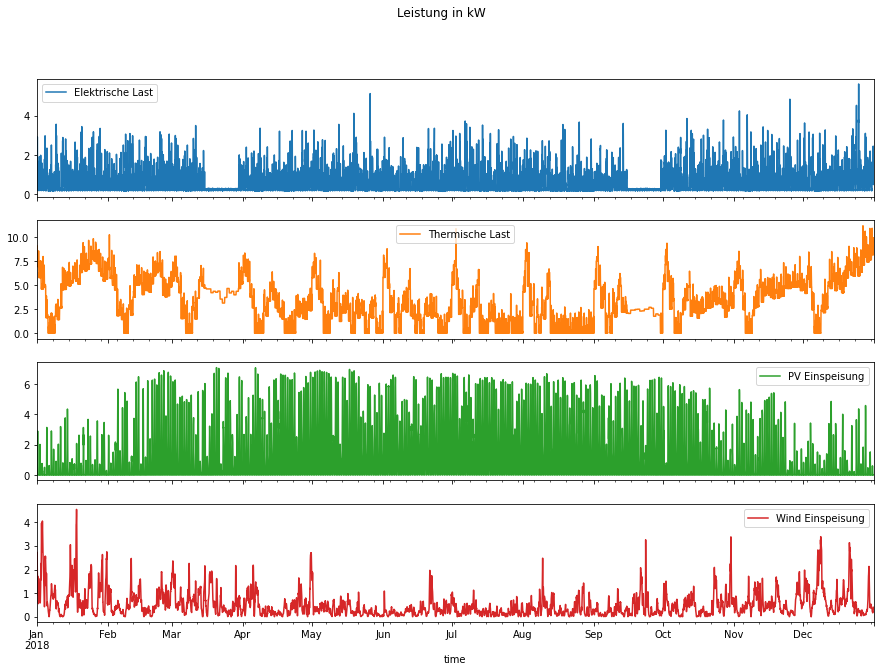

In [6]:
df_figure = pd.concat([electrical_load.sum_kwh, thermal_load.sum_kwh, pv_infeed.electricity,wind_infeed.electricity], axis = 1)
df_figure.columns = ['Elektrische Last', 'Thermische Last', 'PV Einspeisung', 'Wind Einspeisung']
df_figure.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(subplots = True, figsize=(15,10), title= 'Leistung in kW')

# Basiskonfiguration

## Skizze des Basissystems 
<img src="images/Skizze_Basissystem.png">

## Definition der Anlagenparameter

### Komponenten des Haushalts

In [7]:
# PV-Anlage
pv = {"electrical_power": 9.0} #Nennleistung

# Wind-Anlage
wind = {"electrical_power": 5.0} #Nennleistung


# Erdgaskessel
gas_storage = {"thermal_power": 20.0, #Heizleistung
                   "efficiency":0.99, #Wikungsgrad
                   "gas_costs": 7.0} #Kosten in cent/kWh

### Netzanschluss

In [8]:
# Leistungsbezug aus dem Netz
grid_import = {"electrical_power" : 15.0, #Anschlussleistung
                "electricity_price": 30.0} #Preis in cent/kWh

# Leistungsabgabe in das Netz
grid_export = {"electrical_power" : 0.7 * pv["electrical_power"], #70% Kappungsgrenze für Netzstabilität 
                "electricity_revenue": 12.30} #EEG-Vergütung in cent/kWh

## Modellierung mit PyPSA 

### Netzwerk

In [9]:
# (Leeres) Netzwerk mit definierten Zeitschritten
network = pypsa.Network()
network.set_snapshots(pv_infeed.index)
network.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitabschnitt repräsentiert 60 Minuten also 1 Stunde.

### Knoten

In [10]:
# Stromknoten 
network.add("Bus", 
            name = "electricity")

# Wärmeknoten 
network.add("Bus", 
            name = "thermal")

### Lasten

In [11]:
# Elektrische Last am Stromknoten
network.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)

# Thermische Last am Wärmeknoten
network.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)

### Erzeugungseinheiten 

In [12]:
# PV-Anlage am Stromknoten
network.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], #installierte Leistung
            p_max_pu = pv_infeed.p_max_pu, #normierte maximale Leistung
            marginal_cost = 0) #Grenzkosten = 0, da Stromproduktion kostenlos

# Wind-Anlage am Stromknoten
network.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], #installierte Leistung
            p_max_pu = wind_infeed.p_max_pu, #normierte maximale Leistung
            marginal_cost = 0) #Grenzkosten = 0, da Stromproduktion kostenlos

# Heizkessel am Wärmeknoten
network.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = gas_storage["thermal_power"], #installierte Leistung
            efficiency = gas_storage["efficiency"], #Wirkungsgrad
            marginal_cost = gas_storage["gas_costs"]/gas_storage["efficiency"]) #Grenzkosten entsprechen den Kosten für Endenergie

### Netzanschluss definieren

In [13]:
# Netzbezug am Stromknoten
network.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"]) #Grenzkosten entsprechen Strompreis

# Netzeinspeisung am Stromknoten
network.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen (EEG-Vergütung)
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt

## Simulation der Basiskonfiguration

In [14]:
# Simulation für den kompletten Zeitraum:
network.lopf(solver_name = "glpk", pyomo = False) 
# Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.
# Der Parameter lopf optimiert den Einsatz aller Komponenten so, dass die dabei entstehenden Kosten minimal sind.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 8.94e+04


('ok', 'optimal')

### Auswertungsfunktion

In [15]:
##Auswertung der Kosten und Anteile
### Eigenverbrauch an WIND ist zu ergänzen!
def cost_share_evaluation(network):
    '''
    This function evaluate the solved PyPSA network to get the costs, revenues and the share of the selfconsumption.
    
    Parameters
    ----------
    network:            PyPSA Network
                        The solved PyPSA network with all corresponding devices
    Returns
    -------
    results :           dict
                        The dictionary with all the results.
    '''
    
    grid_import = (network.generators_t.p['grid_import'] * network.snapshot_weightings).sum()
    grid_export = (network.generators_t.p['grid_export'] * network.snapshot_weightings).sum()
    self_consumed_pv = (network.generators_t.p['pv'] * network.snapshot_weightings).sum() - grid_export
    self_consumed_wind = (network.generators_t.p['wind'] * network.snapshot_weightings).sum()
    self_consumption_ratio = (self_consumed_pv + self_consumed_wind) / (grid_import + self_consumed_pv + self_consumed_wind)#(Eigenverbrauch über 1 Jahr)/(Gesamtverbrauch über 1 Jahr)
    
    electricity_cost = grid_import * network.generators.marginal_cost['grid_import']
    electricity_revenue = grid_export * network.generators.marginal_cost['grid_export']
    gas_costs = (network.generators_t.p['boiler'] * network.snapshot_weightings).sum() * network.generators.marginal_cost['boiler']
    
    curtailment = ((network.generators_t.p_max_pu['pv'] * network.generators.p_nom['pv'] - network.generators_t.p['pv'])*network.snapshot_weightings).sum()

    results = {"Eigenverbrauchsanteil": self_consumption_ratio,
              "Stromkosten": electricity_cost,
              "Gaskosten": gas_costs,
              "Stromerlöse": -electricity_revenue,
              "Gesamtkosten": electricity_cost + gas_costs + electricity_revenue,
              "Nicht nutzbare Energie": curtailment} #Bei nicht vorhandenem Eigenverbrauch aufgrund der Kappungsgrenze
    results_energy = {'Abregelung': curtailment,
                      'Netzeinspeisung': grid_export,
                      'Eigenverbrauch': self_consumed_pv + self_consumed_wind,
                      'Netzbezug': -grid_import}
                      
    return results, results_energy

In [16]:
results_base, results_energy_base  = cost_share_evaluation(network)

#Ausgabe der Werte als Text
print("Der Eigenverbrauchsanteil am Stromverbrauch in der Basiskonfiguration beträgt "
      +str(round(results_base["Eigenverbrauchsanteil"]*100,2)) #
      +"%. Dabei entstehen Stromkosten von "
      +str(round(results_base["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_base["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_base["Stromerlöse"]/100,2))
      +"€, wobei " +str(round(results_base["Nicht nutzbare Energie"]/100,1))+ "kWh PV-Strom abgeregelt werden muss."
      +" Die Gesamtkosten betragen "+ str(round(results_base["Gesamtkosten"]/100,2)) +"€."
     )

Der Eigenverbrauchsanteil am Stromverbrauch in der Basiskonfiguration beträgt 68.98%. Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1891.83€ und EEG-Erlöse von 1469.02€, wobei 0.1kWh PV-Strom abgeregelt werden muss. Die Gesamtkosten betragen 894.4€.


### Visualisierung der Ergebnisse

<AxesSubplot:xlabel='time'>

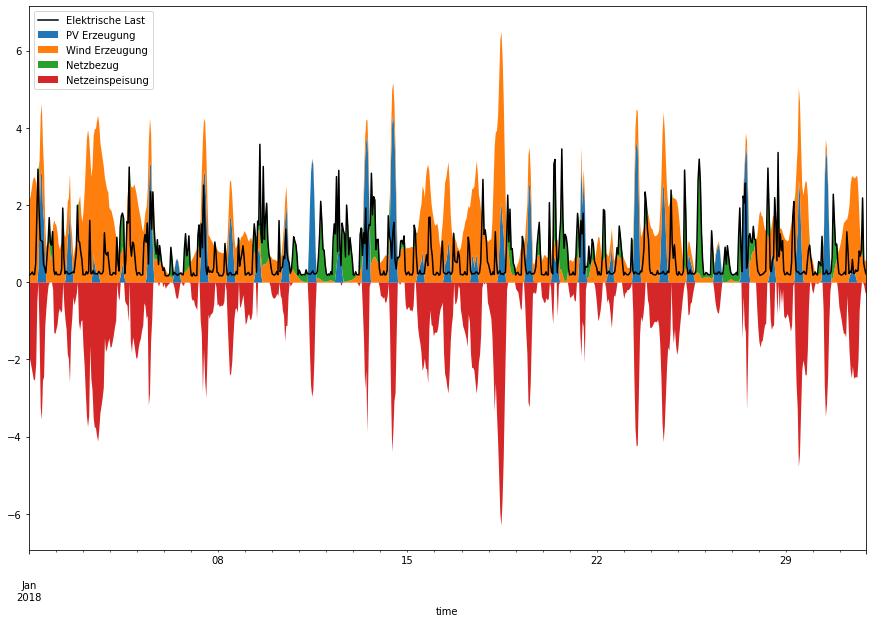

In [17]:
load_figure = network.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
ax = load_figure.loc['2018-01-01 00:00':'2018-01-31 23:00'].plot(legend = True, color = 'black') #Anzeige des Monats Januar für Übersichtlichkeit
df_figure_base = pd.concat([network.generators_t.p['pv'], network.generators_t.p['wind'], network.generators_t.p['grid_import'], -network.generators_t.p['grid_export']], axis = 1)
df_figure_base.columns = ['PV Erzeugung','Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc['2018-01-01 00:00':'2018-01-31 23:00'].plot(legend = True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)


# Optimierung der Basiskonfiguration

## Thermischer Speicher

### Grundaufbau des Basissystems mit thermischem Speicher

In [18]:
# Basisnetzwerk
network_modified = pypsa.Network()
network_modified.set_snapshots(pv_infeed.index)
network_modified.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 60 Minuten also 1 Stunde.

# Stromknoten
network_modified.add("Bus", 
            name = "electricity")

# Wärmeknoten
network_modified.add("Bus", 
            name = "thermal")

# Elektrische Last
network_modified.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)

# Thermische Last
network_modified.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)

# PV-Anlage
network_modified.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], #installierte Leistung
            p_max_pu = pv_infeed.p_max_pu, #normierte maximale Leistung
            marginal_cost = 0) #Grenzkosten = 0, da Stromproduktion kostenlos

# Wind-Anlage
network_modified.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], #installierte Leistung
            p_max_pu = wind_infeed.p_max_pu, #normierte maximale Leistung
            marginal_cost = 0) #Grenzkosten = 0, da Stromproduktion kostenlos

# Heizkessel
network_modified.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = gas_storage["thermal_power"], 
            efficiency = gas_storage["efficiency"], 
            marginal_cost = gas_storage["gas_costs"]/gas_storage["efficiency"]) #Grenzkosten entsprechen Kosten für Endenergie

#Netzbezug
network_modified.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"]) #Grenzkosten entsprechen Strompreis

#Netzeinspeisung
network_modified.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen (EEG-Vergütung)
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt

### Skizze des Systems mit thermischem Speicher
<img src = "images/Skizze_ThermischerSpeicher.png">

### Modell-Erweiterung mit thermischem Speicher

In [19]:
# Hilfsknoten für den Speicher
network_modified.add("Bus", 
            name = "storage_thermal")

# Einspeicherleistung vom Knoten "thermal" zum Knoten "storage_thermal"
network_modified.add("Link", 
            name = "hot_water_storage_charge", 
            bus0 = "thermal", 
            bus1 = "storage_thermal", 
            p_nom = 12) #Einspeicherleistung in kW

# Ausspeicherleistung vom Knoten "storage_thermal" zum Knoten "thermal"
network_modified.add("Link", 
            name = "hot_water_storage_discharge", 
            bus0 = "storage_thermal", 
            bus1 = "thermal", 
            p_nom = 12) #Ausspeicherleistung in kW

# Speicher
network_modified.add("Store", 
            name = "hot_water_storage", 
            bus = "storage_thermal", 
            e_nom = 7, #Kapazität in kWh
            e_cyclic = True) #Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen

### Simulation mit thermischen Speicher

In [20]:
# Simulation für den kompletten Zeitraum:
network_modified.lopf(solver_name = "glpk", pyomo = False) 
#Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.
#Der Parameter lopf optimiert den Einsatz aller Komponenten so, dass die dabei entstehenden Kosten minimal sind.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.48s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 8.94e+04


('ok', 'optimal')

In [21]:
# Ausführung der Auswertungsfunktion
results_modified, results_energy_modified = cost_share_evaluation(network_modified)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_modified["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_modified["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_modified["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_modified["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_modified["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results_modified["Gesamtkosten"]/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_modified["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-results_modified["Gesamtkosten"])/100,2))
      +"€."
      +" Dies ist darauf zurückzuführen, dass der thermische Speicher über den Wärmeknoten lediglich mit dem Heizkessel verbunden ist und eine Einspeicherung durch die flexible Inbetriebnahme keinen Zweck erfüllt."
     )

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 68.98%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1891.83€ und EEG-Erlöse von 1469.02, wobei 0.1kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 894.4€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 0.0 Prozentpunkte und eine Verringerung der Kosten um 0.0€. Dies ist darauf zurückzuführen, dass der thermische Speicher über den Wärmeknoten lediglich mit dem Heizkessel verbunden ist und eine Einspeicherung durch die flexible Inbetriebnahme keinen Zweck erfüllt.


<AxesSubplot:xlabel='time'>

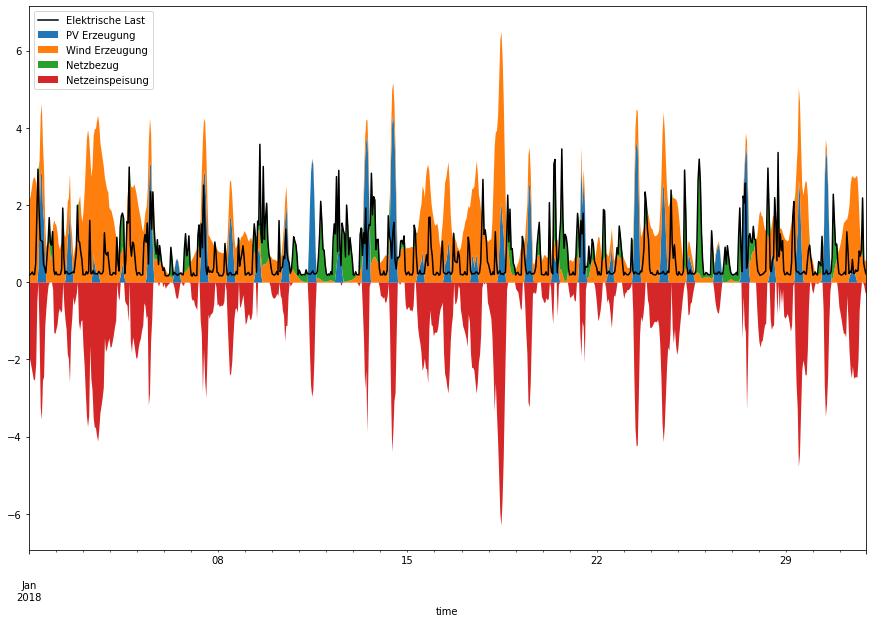

In [22]:
# Visualisierung der Ergebnisse 
load_figure = network_modified.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
ax = load_figure.loc['2018-01-01 00:00':'2018-01-31 23:00'].plot(legend = True, color = 'black') #Zeitraum änderbar (Monatsübersicht)
df_figure_base = pd.concat([network_modified.generators_t.p['pv'], network_modified.generators_t.p['wind'], network_modified.generators_t.p['grid_import'], -network_modified.generators_t.p['grid_export']], axis = 1)
df_figure_base.columns = ['PV Erzeugung','Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc['2018-01-01 00:00':'2018-01-31 23:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)


## Elektrischer Speicher

### Grundaufbau des Basissystems mit elektrischem Speicher

In [23]:
# Basisnetzwerk
network_modified_2 = pypsa.Network()
network_modified_2.set_snapshots(pv_infeed.index)
network_modified_2.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 60 Minuten also 1 Stunde.

# Stromknoten
network_modified_2.add("Bus", 
            name = "electricity")

# Wärmeknoten
network_modified_2.add("Bus", 
            name = "thermal")

# Elektrische Last
network_modified_2.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)

# Thermische Last
network_modified_2.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)

# PV-Anlage
network_modified_2.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

# Wind-Anlage
network_modified_2.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

# Heizkessel
network_modified_2.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = gas_storage["thermal_power"], 
            efficiency = gas_storage["efficiency"], 
            marginal_cost = gas_storage["gas_costs"]/gas_storage["efficiency"])

# Netzbezug
network_modified_2.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

# Netzeinspeisung
network_modified_2.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.

### Skizze des Systems mit elektrischem Speicher
<img src="images/Skizze_Batteriespeicher.png">

### Modell-Erweiterung mit elektrischem Speicher

In [24]:
# Hilfsknoten für elektr. Speicher
network_modified_2.add("Bus", 
            name = "storage_electricity")

# Einspeicherleistung vom Knoten "electricity" zum Knoten "storage_electricity"
network_modified_2.add("Link", 
            name = "electrical_storage_charge", 
            bus0 = "electricity", 
            bus1 = "storage_electricity", 
            p_nom = 2.4, #Ladeleistung in kW
            efficiency = math.sqrt(0.85) #Wirkungsgrad
                    )

# Ausspeicherleistung vom Knoten "storage_electricity" zum Knoten "electricity"
network_modified_2.add("Link", 
            name = "electricity_storage_discharge", 
            bus0 = "storage_electricity", 
            bus1 = "electricity", 
            p_nom = 2.4, #Speicherleistung in kW
            efficiency = math.sqrt(0.85) #Wirkungsgrad
                    )

# Speicher
network_modified_2.add("Store", 
            name = "electricity_storage", 
            bus = "storage_electricity", 
            e_nom = 8, #Kapazität in kWh
            e_cyclic = True)#Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen

### Simulation mit Batteriespeicher

In [25]:
# Simulation für den kompletten Zeitraum:
network_modified_2.lopf(solver_name = "glpk", pyomo = False) 
#Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.
#Der Parameter lopf optimiert den Einsatz aller Komponenten so, dass die dabei entstehenden Kosten minimal sind.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.72s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 6.72e+04


('ok', 'optimal')

In [26]:
# Ausführung der Auswertungsfunktion
results_modified_2, results_energy_modified_2 = cost_share_evaluation(network_modified_2)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_modified_2["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_modified_2["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_modified_2["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_modified_2["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_modified_2["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results_modified_2["Gesamtkosten"]/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_modified_2["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-results_modified_2["Gesamtkosten"])/100,2))
      +"€."
      +" Die, bei mangelndem Eigenverbrauch, überschüssige Energie wird in die Batterie ohne Selbstentladungsverluste eingespeichert und kann diese, von der Erzeugung entkoppelt, flexibel abgeben. Die thermischen Energiekosten bleiben dementsprechend unbeeinflusst."
     )

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 95.81%.
 Dabei entstehen Stromkosten von 66.76€, Gaskosten von 1891.83€ und EEG-Erlöse von 1286.95, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 671.63€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 26.83 Prozentpunkte und eine Verringerung der Kosten um 222.76€. Die, bei mangelndem Eigenverbrauch, überschüssige Energie wird in die Batterie ohne Selbstentladungsverluste eingespeichert und kann diese, von der Erzeugung entkoppelt, flexibel abgeben. Die thermischen Energiekosten bleiben dementsprechend unbeeinflusst.


In [27]:
# Visualisierung der Ergebnisse
load_figure = network_modified_2.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
ax = load_figure.loc['2018-01-01 00:00':'2018-01-31 23:00'].plot(legend = True, color = 'black')
df_figure_base = pd.concat([network_modified_2.generators_t.p['pv'], network_modified_2.generators_t.p['wind'], network_modified_2.generators_t.p['grid_import'], -network_modified_2.generators_t.p['grid_export']], axis = 1)
df_figure_base.columns = ['PV Erzeugung','Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc['2018-01-01 00:00':'2018-01-31 23:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)


<AxesSubplot:xlabel='time'>

## Wärmepumpe

### Grundaufbau des Basissystems mit Wärmepumpe

In [28]:
# Basisnetzwerk
network_modified_3 = pypsa.Network()
network_modified_3.set_snapshots(pv_infeed.index)
network_modified_3.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 60 Minuten also 1 Stunde.

# Stromknoten
network_modified_3.add("Bus", 
            name = "electricity")

# Wärmeknoten
network_modified_3.add("Bus", 
            name = "thermal")

# Elektrische Last
network_modified_3.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)

# Thermische Last
network_modified_3.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)

# PV-Anlage
network_modified_3.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

# Wind-Anlage
network_modified_3.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

# Heizkessel
network_modified_3.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = gas_storage["thermal_power"], 
            efficiency = gas_storage["efficiency"], 
            marginal_cost = gas_storage["gas_costs"]/gas_storage["efficiency"])

# Netzbezug
network_modified_3.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

# Netzeinspeisung
network_modified_3.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.

### Skizze des Basissystems mit Wärmepumpe
<img src="images/Skizze_Wärmepumpe.png">

### Modell-Erweiterung mit Wärmepumpe

In [29]:
#Wärmepumpe vom Knoten "electricity" zum Knoten "thermal"
# Modell: Vaillant aroTHERM VWL Kältesplit | VWL 35/5 AS (Luft/Wasser Wärmepumpe)
# https://www.vaillant.at/privatanwender/produkte/luft-wasser-warmepumpe-arotherm-vwl-kaltesplit-mit-unitower-70784.html
# Kosten: 4.988,00 €
# Heizleistung bei A2/W35 in kW: 2,46
# COP bei A2/W35: 3,75
network_modified_3.add("Link", 
            name = "heat_pump", 
            bus0 = "electricity", 
            bus1 = "thermal", 
            p_nom = 2.46, #Beispielhafte Heizleistung 
            efficiency = 3.75 #Beispielhafte Leistungszahl
                      )

### Simulation mit Wärmepumpe

In [30]:
# Simulation für den kompletten Zeitraum:
network_modified_3.lopf(solver_name = "glpk", pyomo = False) 
#Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.
#Der Parameter lopf optimiert den Einsatz aller Komponenten so, dass die dabei entstehenden Kosten minimal sind.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 0.82s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 4.44e+04


('ok', 'optimal')

In [31]:
# Ausführung der Auswertungsfunktion
results_modified_3, results_energy_modified_3 = cost_share_evaluation(network_modified_3)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_modified_3["Eigenverbrauchsanteil"]*100,2)) #Umrechnung in % und Rundung auf 2 Dezimalstellen
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_modified_3["Stromkosten"]/100,2)) #Umrechnung in € und Rundung auf 2 Dezimalstellen
      +"€, Gaskosten von "
      +str(round(results_modified_3["Gaskosten"]/100,2)) #Umrechnung in € und Rundung auf 2 Dezimalstellen
      +"€ und EEG-Erlöse von "
      +str(round(results_modified_3["Stromerlöse"]/100,2)) #Umrechnung in € und Rundung auf 2 Dezimalstellen
      +", wobei " +str(round(results_modified_3["Nicht nutzbare Energie"]/100,1)) #Umrechnung in € und Rundung auf 2 Dezimalstellen
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results_modified_3["Gesamtkosten"]/100,2)) #Umrechnung in € und Rundung auf 2 Dezimalstellen
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_modified_3["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2)) #Umrechnung in € und Rundung auf 2 Dezimalstellen
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-results_modified_3["Gesamtkosten"])/100,2)) #Umrechnung in € und Rundung auf 2 Dezimalstellen
      +"€."
      +" Durch die Koppelung der thermischen und elektrischen Last mithilfe der Wärmepumpe kann die, zur Verfügung stehende, regenerative Energie in kalten Monaten auch zur Wärmebereitstellung verwendet werden. Die Gaskosten sinken entsprechend stark. Dadurch wird im Vergleich zur Batterie jedoch auch mehr Strom aus dem Netz bezogen."
     )

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 80.78%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1067.14€ und EEG-Erlöse von 1094.95, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 443.78€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 11.8 Prozentpunkte und eine Verringerung der Kosten um 450.61€. Durch die Koppelung der thermischen und elektrischen Last mithilfe der Wärmepumpe kann die, zur Verfügung stehende, regenerative Energie in kalten Monaten auch zur Wärmebereitstellung verwendet werden. Die Gaskosten sinken entsprechend stark. Dadurch wird im Vergleich zur Batterie jedoch auch mehr Strom aus dem Netz bezogen.


<AxesSubplot:xlabel='time'>

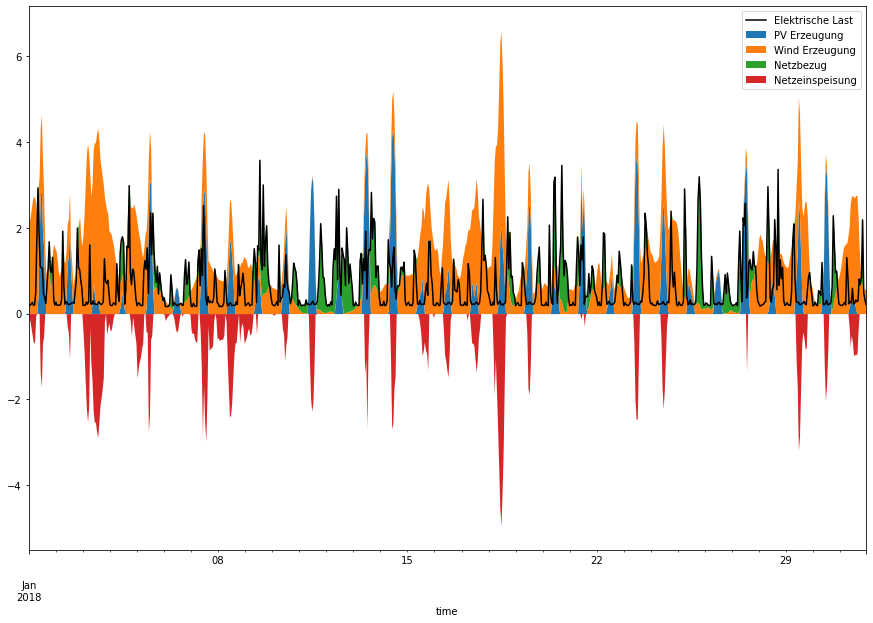

In [32]:
load_figure = network_modified_3.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
ax = load_figure.loc['2018-01-01 00:00':'2018-01-31 23:00'].plot(legend = True, color = 'black')
df_figure_base = pd.concat([network_modified_3.generators_t.p['pv'], network_modified_3.generators_t.p['wind'], network_modified_3.generators_t.p['grid_import'], -network_modified_3.generators_t.p['grid_export']], axis = 1)
df_figure_base.columns = ['PV Erzeugung','Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc['2018-01-01 00:00':'2018-01-31 23:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)


## Vergleich der verschiedenen Erweiterungen

In [33]:
energy_figure = pd.DataFrame([results_energy_base, results_energy_modified, results_energy_modified_2, results_energy_modified_3 ], index = ['Basis', 'Thermischer Speicher', 'Batteriespeicher', 'Wärmepumpe'])

<AxesSubplot:title={'center':'Elektrizitätsbilanz in kWh'}>

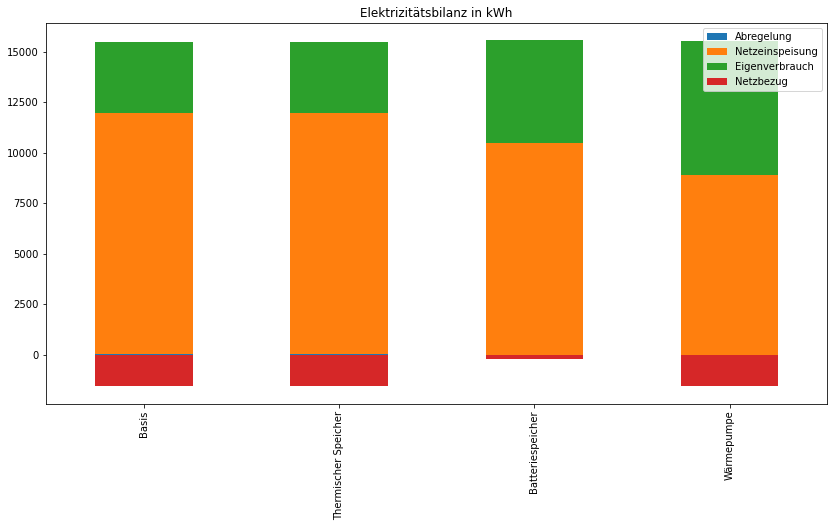

In [34]:
energy_figure.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh')

# Grenzen der Modellierung

## Allgemein

- Last ist nur durch ein Beispiel gegeben
- Zeitliche Auflösung ungenau 
- Keine Abbildung variierender Kosten
- Leitungsverluste werden vernachlässigt

## Thermischer Speicher

- Speicher wird als verlustfrei angenommen (unendliche Speicherdauer)
- Kopplung mit Heizkessel sinnlos

## Batteriespeicher

- Batterie wird als verlustfrei angenommen (unendliche Speicherdauer)

## Wärmepumpe

- Konst. COP/Heizleistung unrealistisch (abhängig von etlichen Faktoren)
- Mögliche Kühlung wird vernachlässigt